# Projeto Final - CDII (FACOM32701)

**Tema:** PROJETO 6 - Análise de Agrupamentos de Desmatamento e Uso do Solo  
**Grupo:**   
Gustavo Antunes de Souza - 12311BSI276  
Millena Lins dos Santos - 12311BSI292  

---

## Objetivos do projeto

Este projeto aplica técnicas não supervisionadas para identificar padrões naturais de desmatamento e uso/cobertura do solo entre municípios brasileiros, com foco em:

- Como os padrões de desmatamento se diferenciam entre biomas;
- Identificação de padrões de “desmatamento evitado” (conservação/baixa pressão);
- Relação entre desmatamento e indicadores de uso/cobertura do solo.

---

## Fontes de dados (públicas)

- **INPE / TerraBrasilis (PRODES):** dados anuais de desmatamento por município (arquivos `terrabrasilis_*.csv`).  
- **IBGE:** bioma predominante por município (`Bioma_Predominante_por_Municipio_2024.csv`).  
- **MapBiomas (Coleção 10.1):** estatísticas de uso/cobertura por município (arquivo `MAPBIOMAS_BRAZIL-COVERAGE_STATISTICS-COL.10.1-MUNICIPALITIES_STATES_BIOMES.xlsx`).

> **Execução no Colab:** faça upload dos arquivos na pasta do ambiente (painel à esquerda - Files - Upload).


In [84]:
# =========================
# 1) Imports e configurações
# =========================
import os
import glob
import re
import unicodedata
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

from scipy.cluster.hierarchy import linkage, dendrogram, fcluster


In [85]:
# =======================================
# 2) Funções utilitárias (padronização etc)
# =======================================
def normalize_text(s: str) -> str:
    """Normaliza texto para facilitar merges por nome (remove acentos, espaços duplos, caixa)."""
    if pd.isna(s):
        return ""
    s = str(s).strip().upper()
    s = unicodedata.normalize("NFKD", s)
    s = "".join(ch for ch in s if not unicodedata.combining(ch))
    s = re.sub(r"\s+", " ", s)
    return s

def parse_ptbr_number(x):
    """Converte número no padrão pt-BR (1.234,56) para float (1234.56)."""
    if pd.isna(x):
        return np.nan
    s = str(x).strip()
    s = s.replace(".", "").replace(",", ".")
    try:
        return float(s)
    except ValueError:
        return np.nan

def find_first_existing(candidates):
    for p in candidates:
        if os.path.exists(p):
            return p
    return None


## 3) Carregamento dos dados

### 3.1 PRODES / TerraBrasilis (desmatamento por município)

Neste projeto, usamos os arquivos com colunas:
- `mun` (nome do município)
- `geocode_ibge` (código IBGE)
- `year`
- `area km²` (área desmatada no ano)

> Observação: para cada bioma existem múltiplos CSVs; será selecionado automaticamente o arquivo com maior número de municípios para cada bioma.


In [86]:
# ==================================================
# 3.1) PRODES / TerraBrasilis - leitura e consolidação
# ==================================================
tb_files = sorted(glob.glob("terrabrasilis_*.csv"))
print(f"Arquivos TerraBrasilis encontrados: {len(tb_files)}")
tb_files[:10]


Arquivos TerraBrasilis encontrados: 32


['terrabrasilis_amazon_24_02_2026_1771957719503.csv',
 'terrabrasilis_amazon_24_02_2026_1771957721056.csv',
 'terrabrasilis_amazon_24_02_2026_1771957723938.csv',
 'terrabrasilis_amazon_24_02_2026_1771957726728.csv',
 'terrabrasilis_amazon_nf_24_02_2026_1771957736272.csv',
 'terrabrasilis_amazon_nf_24_02_2026_1771957739680.csv',
 'terrabrasilis_amazon_nf_24_02_2026_1771957743099.csv',
 'terrabrasilis_amazon_nf_24_02_2026_1771957745858.csv',
 'terrabrasilis_caatinga_24_02_2026_1771957893205.csv',
 'terrabrasilis_caatinga_24_02_2026_1771957896173.csv']

In [87]:
def infer_biome_from_filename(fname: str) -> str:
    base = os.path.basename(fname).lower()
    if "legal_amazon" in base:
        return "Amazônia Legal"
    if "amazon_nf" in base:
        return "Amazônia (Não Floresta)"
    if "amazon" in base:
        return "Amazônia"
    if "cerrado" in base:
        return "Cerrado"
    if "caatinga" in base:
        return "Caatinga"
    if "mata_atlantica" in base:
        return "Mata Atlântica"
    if "pantanal" in base:
        return "Pantanal"
    if "pampa" in base:
        return "Pampa"
    return "Desconhecido"

def load_terrabrasilis_csv(path: str) -> pd.DataFrame:
    with open(path, "r", encoding="utf-8", errors="ignore") as f:
        first = f.readline()
    sep = ";" if ";" in first else ","
    df = pd.read_csv(path, sep=sep)
    df.columns = [c.strip() for c in df.columns]

    # área
    area_candidates = [c for c in df.columns if "area" in c.lower()]
    if area_candidates:
        area_col = area_candidates[0]
        df[area_col] = df[area_col].map(parse_ptbr_number)
        df = df.rename(columns={area_col: "area_km2"})

    # geocode
    geo_candidates = [c for c in df.columns if "geocode" in c.lower()]
    if geo_candidates:
        df = df.rename(columns={geo_candidates[0]: "geocode_ibge"})

    return df

# seleciona apenas arquivos anuais com município + geocode + year
tb_annual = []
for p in tb_files:
    try:
        d = load_terrabrasilis_csv(p)
    except Exception:
        continue
    cols = set([c.lower() for c in d.columns])
    if {"mun", "geocode_ibge", "year"}.issubset(cols) and ("area_km2" in d.columns):
        d["bioma_origem"] = infer_biome_from_filename(p)
        d["source_file"] = os.path.basename(p)
        keep_cols = ["geocode_ibge", "mun", "uf", "year", "area_km2", "bioma_origem", "source_file"]
        d = d[[c for c in keep_cols if c in d.columns]]
        tb_annual.append(d)

print("Arquivos TerraBrasilis anuais (município) detectados:", len(tb_annual))


Arquivos TerraBrasilis anuais (município) detectados: 16


In [88]:
# Para cada bioma, escolhe o arquivo anual mais completo (maior número de municípios distintos)
tb_best = []
for biome in sorted({d["bioma_origem"].iloc[0] for d in tb_annual}):
    dfs = [d for d in tb_annual if d["bioma_origem"].iloc[0] == biome]
    best = max(dfs, key=lambda x: x["geocode_ibge"].nunique())
    tb_best.append(best)

prodes_long = pd.concat(tb_best, ignore_index=True)
prodes_long["geocode_ibge"] = prodes_long["geocode_ibge"].astype(str).str.replace(r"\D", "", regex=True)

print("Biomas/recortes selecionados:", prodes_long["bioma_origem"].unique())
print("Anos disponíveis:", int(prodes_long["year"].min()), "→", int(prodes_long["year"].max()))
display(prodes_long.groupby("bioma_origem")["geocode_ibge"].nunique().sort_values(ascending=False).to_frame("n_municipios"))
prodes_long.head()


Biomas/recortes selecionados: ['Amazônia' 'Amazônia (Não Floresta)' 'Amazônia Legal' 'Caatinga'
 'Cerrado' 'Mata Atlântica' 'Pampa' 'Pantanal']
Anos disponíveis: 2001 → 2025


,n_municipios
bioma_origem,
Mata Atlântica,3083
Cerrado,1433
Caatinga,1209
Amazônia Legal,773
Amazônia,559
Amazônia (Não Floresta),559
Pampa,230
Pantanal,22


,geocode_ibge,mun,uf,year,area_km2,bioma_origem,source_file
0,1303957,São Sebastião do Uatumã,Amazonas,2025,1.21,Amazônia,terrabrasilis_amazon_24_02_2026_1771957726728.csv
1,1702307,Arapoema,Tocantins,2025,0.00,Amazônia,terrabrasilis_amazon_24_02_2026_1771957726728.csv
2,1500909,Augusto Corrêa,Pará,2025,0.00,Amazônia,terrabrasilis_amazon_24_02_2026_1771957726728.csv
3,1708254,Tabocão,Tocantins,2025,0.00,Amazônia,terrabrasilis_amazon_24_02_2026_1771957726728.csv
4,2111508,São Mateus do Maranhão,Maranhão,2025,0.00,Amazônia,terrabrasilis_amazon_24_02_2026_1771957726728.csv


### 3.2 IBGE - Bioma predominante por município

Usamos o arquivo do IBGE para mapear, por código IBGE, o bioma predominante de cada município.


In [89]:
# ============================
# 3.2) IBGE - Bioma Predominante
# ============================

import pandas as pd
import numpy as np
import unicodedata
import re

ibge_candidates = [
    "Bioma_Predominante_por_Municipio_2024.csv",
    "Bioma_Predominante_por_Municipio_2024.xlsx",
    "Lista_Municipio_Bioma_250mil.xls",
]

ibge_path = find_first_existing(ibge_candidates)
print("Arquivo IBGE selecionado:", ibge_path)

if ibge_path is None:
    raise FileNotFoundError(
        "Arquivo do IBGE não encontrado. Faça upload de "
        "'Bioma_Predominante_por_Municipio_2024.csv' (ou equivalente)."
    )

def normalize_colname(s: str) -> str:
    s = str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = s.strip().lower()
    # corrige leetspeak/artefatos comuns (caso apareça algo tipo 'igeoca3digo')
    s = s.replace("3", "o").replace("0", "o").replace("1", "l").replace("5", "s")
    s = re.sub(r"\s+", " ", s)
    return s

def read_ibge_robust(path: str) -> pd.DataFrame:
    if path.lower().endswith(".csv"):
        # tenta separadores comuns; IBGE frequentemente é ';'
        for sep in [";", ",", "\t", "|"]:
            try:
                df_try = pd.read_csv(path, dtype=str, sep=sep, encoding="utf-8-sig", engine="python")
                # se veio só 1 coluna gigante, não é esse separador
                if df_try.shape[1] > 1:
                    return df_try
            except Exception:
                pass
        # fallback final: deixa o pandas tentar
        return pd.read_csv(path, dtype=str, encoding="utf-8-sig", engine="python")
    else:
        return pd.read_excel(path, dtype=str)

ibge = read_ibge_robust(ibge_path)

# normaliza nomes das colunas
ibge.columns = [normalize_colname(c) for c in ibge.columns]
print("Colunas detectadas no IBGE:", ibge.columns.tolist())

# detectar coluna de geocódigo (mesmo se estiver “estranha”)
geo_col = None
for c in ibge.columns:
    cl = re.sub(r"[^a-z]", "", c)  # só letras
    # pega qualquer variação com "geocod" (geocodigo, geocod, etc.)
    if "geocod" in cl or cl in ("cdgeocmu", "codigoibge", "codibge"):
        geo_col = c
        break

# fallback: procura colunas que contenham "geo" e "cod"
if geo_col is None:
    for c in ibge.columns:
        if ("geo" in c) and ("cod" in c or "codigo" in c):
            geo_col = c
            break

if geo_col is None:
    raise KeyError(
        "Não foi possível detectar a coluna de geocódigo no IBGE. "
        f"Colunas disponíveis: {ibge.columns.tolist()}"
    )

# detectar coluna de bioma
biome_col = None
for c in ibge.columns:
    if "bioma" in c:
        biome_col = c
        break

if biome_col is None:
    raise KeyError(
        "Não foi possível detectar a coluna de bioma no IBGE. "
        f"Colunas disponíveis: {ibge.columns.tolist()}"
    )

# detectar coluna de UF (útil para merge com MapBiomas por município+UF)
uf_col = None
for c in ibge.columns:
    if c in ("sigla da uf", "sigla uf", "uf", "estado", "sg_uf"):
        uf_col = c
        break
if uf_col is None:
    # tenta achar algo que tenha "uf"
    for c in ibge.columns:
        if "uf" == c or c.endswith(" uf") or "sigla" in c and "uf" in c:
            uf_col = c
            break

# detectar coluna de nome do município (útil para merge)
mun_col = None
for c in ibge.columns:
    if ("municip" in c) or ("munic" in c) or ("nome do" in c and "mun" in c):
        mun_col = c
        break

ibge_clean_cols = [geo_col, biome_col] + ([uf_col] if uf_col else []) + ([mun_col] if mun_col else [])
ibge_clean = ibge[ibge_clean_cols].copy()

ibge_clean = ibge_clean.rename(columns={
    geo_col: "geocode_ibge",
    biome_col: "bioma_ibge",
    **({uf_col: "uf_ibge"} if uf_col else {}),
    **({mun_col: "mun_ibge"} if mun_col else {}),
})

# limpa geocode -> só dígitos
ibge_clean["geocode_ibge"] = (
    ibge_clean["geocode_ibge"]
    .astype(str)
    .str.replace(r"\D", "", regex=True)
)

# remove geocodes inválidos
ibge_clean = ibge_clean.dropna(subset=["geocode_ibge"])
ibge_clean = ibge_clean[ibge_clean["geocode_ibge"].str.len().between(6, 7)]
ibge_clean = ibge_clean.drop_duplicates("geocode_ibge")

display(ibge_clean.head())
print("Municípios únicos no IBGE:", ibge_clean["geocode_ibge"].nunique())

Arquivo IBGE selecionado: Bioma_Predominante_por_Municipio_2024.csv
Colunas detectadas no IBGE: ['geocodigo', 'nome do municipio', 'sigla da uf', 'bioma predominante']


,geocode_ibge,bioma_ibge,uf_ibge,mun_ibge
0,1100015,Amazônia,RO,Alta Floresta D'Oeste
1,1100023,Amazônia,RO,Ariquemes
2,1100031,Amazônia,RO,Cabixi
3,1100049,Amazônia,RO,Cacoal
4,1100056,Amazônia,RO,Cerejeiras


Municípios únicos no IBGE: 5572


### 3.3 MapBiomas - uso/cobertura por município (Coleção 10.1)

O arquivo `COVERAGE_10.1` contém uma linha por município X classe e colunas de anos (1985…2024), com valores de área.

Como o MapBiomas pode não trazer o código IBGE diretamente no arquivo municipal, faremos o merge pelo **nome do município + UF** (normalizados).


In [90]:
# ============================
# 3.3) MapBiomas - coverage stats
# ============================

import pandas as pd
import numpy as np
import re
import unicodedata

mb_candidates = [
    "MAPBIOMAS_BRAZIL-COVERAGE_STATISTICS-COL.10.1-MUNICIPALITIES_STATES_BIOMES.xlsx",
    "MAPBIOMAS_BRAZIL-COVERAGE_STATISTICS-COL.10.1-MUNICIPALITIES_STATES_BIOMES (1).xlsx",
]
mb_path = find_first_existing(mb_candidates)
print("Arquivo MapBiomas selecionado:", mb_path)

if mb_path is None:
    raise FileNotFoundError("Arquivo MapBiomas não encontrado. Faça upload do .xlsx municipal.")

mb = pd.read_excel(mb_path, sheet_name="COVERAGE_10.1")

print("Colunas detectadas no MapBiomas (COVERAGE_10.1):")
print(list(mb.columns))

# detectar anos (colunas '1985'...'2024')
year_cols = [c for c in mb.columns if re.fullmatch(r"\d{4}", str(c).strip())]
year_cols = sorted(year_cols, key=lambda x: int(str(x)))

print("Total de linhas MapBiomas:", mb.shape[0])
print("Anos detectados:", (year_cols[0], year_cols[-1]) if year_cols else "NENHUM")
print("Total anos:", len(year_cols))

required_cols = ["municipality", "state_acronym", "biome", "class_level_0", "class_level_1"]
missing = [c for c in required_cols if c not in mb.columns]
if missing:
    raise KeyError(
        f"Colunas esperadas não encontradas na aba COVERAGE_10.1: {missing}. "
        f"Colunas disponíveis: {mb.columns.tolist()}"
    )

# normalização de texto (para merges)
def normalize_text(s):
    s = "" if pd.isna(s) else str(s)
    s = unicodedata.normalize("NFKD", s).encode("ascii", "ignore").decode("utf-8")
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    return s

mb["mun_norm"] = mb["municipality"].map(normalize_text)
mb["uf_norm"] = mb["state_acronym"].map(normalize_text)

display(mb.head())

Arquivo MapBiomas selecionado: MAPBIOMAS_BRAZIL-COVERAGE_STATISTICS-COL.10.1-MUNICIPALITIES_STATES_BIOMES.xlsx
Colunas detectadas no MapBiomas (COVERAGE_10.1):
['country', 'biome', 'state', 'state_acronym', 'municipality', 'class_id', 'class_level_0', 'class_level_1', 'class_level_2', 'class_level_3', 'class_level_4', 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024]
Total de linhas MapBiomas: 78818
Anos detectados: (1985, 2024)
Total anos: 40


,country,biome,state,state_acronym,municipality,class_id,class_level_0,class_level_1,class_level_2,class_level_3,...,2017,2018,2019,2020,2021,2022,2023,2024,mun_norm,uf_norm
0,Brasil,Amazônia,Acre,AC,Acrelândia,0,Undefined,6. Not Observed,6. Not Observed,6. Not Observed,...,16.379696,14.794822,14.970546,15.234995,14.002384,14.794761,14.178737,15.234836,acrelandia,ac
1,Brasil,Amazônia,Acre,AC,Acrelândia,3,Natural,1. Forest,1.1. Forest Formation,1.1. Forest Formation,...,57786.236961,57181.401709,55739.605360,53993.083542,52182.020497,49368.132731,46946.282841,45632.716365,acrelandia,ac
2,Brasil,Amazônia,Acre,AC,Acrelândia,6,Natural,1. Forest,1.4 Floodable Forest,1.4 Floodable Forest,...,1541.061285,1532.344358,1533.047789,1537.978636,1520.461675,1507.597594,1486.986055,1520.181600,acrelandia,ac
3,Brasil,Amazônia,Acre,AC,Acrelândia,11,Natural,2. Non Forest Natural Formation,2.1. Wetland,2.1. Wetland,...,24.751571,28.273405,35.753658,46.056572,45.968447,24.835715,19.554040,21.051771,acrelandia,ac
4,Brasil,Amazônia,Acre,AC,Acrelândia,12,Natural,2. Non Forest Natural Formation,2.2. Grassland,2.2. Grassland,...,52.763268,40.256034,65.980574,50.297927,86.857863,93.906317,78.226264,36.467106,acrelandia,ac


In [91]:
# Agregação por macro-classe (class_level_0) e uma proxy de agropecuária (Farming)
mb_work = mb.copy()
mb_work["mun_norm"] = mb_work["municipality"].map(normalize_text)
mb_work["uf_norm"] = mb_work["state_acronym"].map(normalize_text)

mb_long = mb_work[["mun_norm", "uf_norm", "class_level_0", "class_level_1"] + year_cols].copy()

mb_l0 = mb_long.groupby(["mun_norm", "uf_norm", "class_level_0"], as_index=False)[year_cols].sum()

mb_farming = mb_long[mb_long["class_level_1"].astype(str).str.contains("Farming", case=False, na=False)].copy()
mb_farming = mb_farming.groupby(["mun_norm", "uf_norm"], as_index=False)[year_cols].sum()
mb_farming["class_level_0"] = "Farming (MapBiomas)"
mb_l0 = pd.concat([mb_l0, mb_farming[["mun_norm","uf_norm","class_level_0"]+year_cols]], ignore_index=True)

mb_l0.head()


,mun_norm,uf_norm,class_level_0,1985,1986,1987,1988,1989,1990,1991,...,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024
0,abadia de goias,go,Antropic,10448.706662,10699.414136,10907.625484,10997.247850,11062.704868,11145.305103,11238.871770,...,11796.938935,11749.728037,11716.313012,11687.098932,11685.903440,11697.727617,11720.431121,11718.802200,11695.924273,11731.140617
1,abadia de goias,go,Natural,3758.226431,3514.542506,3316.526732,3233.586547,3176.698415,3112.351595,3036.780925,...,2474.868147,2510.855660,2538.186732,2564.487486,2567.996893,2560.113078,2539.637016,2533.555407,2533.984723,2488.143903
2,abadia de goias,go,Natural/Antropic,128.790939,121.767391,111.571817,104.889636,96.320749,78.067334,60.071337,...,63.916950,75.140336,81.224288,84.137614,81.823700,77.883337,75.655896,83.366426,105.815037,116.439512
3,abadia dos dourados,mg,Antropic,57220.899061,58634.849244,59014.772560,58926.289270,59101.001553,59535.361602,59488.946795,...,64131.182471,63926.999834,64021.821407,63676.961767,63269.043955,63266.100965,63285.567018,62600.459771,62583.366094,62966.175266
4,abadia dos dourados,mg,Natural,30427.548679,28994.741755,28623.485676,28768.534832,28608.154870,28209.389130,28335.306700,...,23798.636147,24007.065511,23917.086695,24254.645607,24667.067621,24682.751965,24670.337034,25358.843199,25377.296817,24999.159872


## 4) Construção do dataset final (município agregado)

### 4.1 Features de desmatamento (PRODES)

Agregamos a série anual por município criando indicadores:

- Total no período
- Média, mediana, desvio padrão
- Tendência temporal (slope)
- Pressão recente (últimos 3 anos)
- Anos com desmatamento zero (proxy de conservação)


In [92]:
# ============================
# 4.1) Features PRODES por município
# ============================
prodes = prodes_long.copy()
prodes["mun_norm"] = prodes["mun"].map(normalize_text)
prodes["uf_norm"] = prodes["uf"].map(normalize_text)

ymin, ymax = int(prodes["year"].min()), int(prodes["year"].max())
recent_years = list(range(max(ymin, ymax-2), ymax+1))

def slope_time(y, x):
    if len(y) < 2:
        return np.nan
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=float)
    x = x - x.mean()
    denom = (x**2).sum()
    if denom == 0:
        return np.nan
    return (x*y).sum()/denom

agg = []
for (geo, mun_norm, uf_norm), g in prodes.groupby(["geocode_ibge","mun_norm","uf_norm"]):
    g = g.sort_values("year")
    areas = g["area_km2"].values
    years = g["year"].values

    total = np.nansum(areas)
    mean = np.nanmean(areas)
    median = np.nanmedian(areas)
    std = np.nanstd(areas)
    mx = np.nanmax(areas)
    sl = slope_time(areas, years)
    zeros = int(np.sum(np.isclose(areas, 0.0)))

    recent = g[g["year"].isin(recent_years)]["area_km2"].sum()
    ratio_recent = (recent / total) if total > 0 else np.nan

    agg.append({
        "geocode_ibge": geo,
        "mun_norm": mun_norm,
        "uf_norm": uf_norm,
        "desmat_total_km2": total,
        "desmat_media_km2_ano": mean,
        "desmat_mediana_km2_ano": median,
        "desmat_std_km2": std,
        "desmat_max_km2": mx,
        "desmat_slope_km2_por_ano": sl,
        "anos_zero": zeros,
        "desmat_ult_3anos_km2": recent,
        "frac_ult_3anos": ratio_recent,
        "anos_disponiveis": int(len(g)),
    })

prodes_feat = pd.DataFrame(agg)
print("Features PRODES:", prodes_feat.shape)
prodes_feat.head()


Features PRODES: (5570, 13)


,geocode_ibge,mun_norm,uf_norm,desmat_total_km2,desmat_media_km2_ano,desmat_mediana_km2_ano,desmat_std_km2,desmat_max_km2,desmat_slope_km2_por_ano,anos_zero,desmat_ult_3anos_km2,frac_ult_3anos,anos_disponiveis
0,1100015,alta floresta d'oeste,rondonia,696.54,11.805763,10.13,8.504122,30.01,0.521797,2,50.45,0.072429,59
1,1100023,ariquemes,rondonia,451.36,7.650169,4.13,8.137175,31.39,0.400348,1,35.88,0.079493,59
2,1100031,cabixi,rondonia,96.36,1.633220,0.70,2.092958,7.19,0.050671,11,6.02,0.062474,59
3,1100049,cacoal,rondonia,157.58,2.670847,2.31,3.618369,18.28,0.176905,16,13.56,0.086052,59
4,1100056,cerejeiras,rondonia,252.54,4.280339,2.23,6.390977,39.81,0.186905,2,27.61,0.109329,59


### 4.2 Features de uso/cobertura (MapBiomas)

A partir da série (1985…2024), construímos indicadores por município:

- Natural, Anthropogenic e Farming no último ano
- Mudança entre primeiro e último ano
- Frações relativas no último ano (para comparar municípios de tamanhos diferentes)


In [93]:
# ============================
# 4.2) Features MapBiomas por município
# ============================

mb_year_min, mb_year_max = min(year_cols), max(year_cols)

def build_mb_features(mb_l0: pd.DataFrame) -> pd.DataFrame:

    keep = ["Natural", "Antropic", "Farming (MapBiomas)"]

    mbk = mb_l0[mb_l0["class_level_0"].isin(keep)].copy()

    out_rows = []

    for (mun_norm, uf_norm), g in mbk.groupby(["mun_norm","uf_norm"]):

        row = {"mun_norm": mun_norm, "uf_norm": uf_norm}
        total_last = 0.0

        for cls in keep:

            gg = g[g["class_level_0"] == cls]

            a_first = float(gg[mb_year_min].sum()) if not gg.empty else np.nan
            a_last  = float(gg[mb_year_max].sum()) if not gg.empty else np.nan

            key = cls.lower().replace(" ", "_").replace("(", "").replace(")", "")

            row[f"mb_{key}__{mb_year_min}"] = a_first
            row[f"mb_{key}__{mb_year_max}"] = a_last
            row[f"mb_delta_{key}"] = (
                a_last - a_first
                if (not np.isnan(a_last) and not np.isnan(a_first))
                else np.nan
            )

            if not np.isnan(a_last):
                total_last += a_last

        row["mb_total_last"] = total_last if total_last > 0 else np.nan

        if total_last and not np.isnan(total_last) and total_last > 0:
            for cls in keep:
                key = cls.lower().replace(" ", "_").replace("(", "").replace(")", "")
                row[f"mb_frac_{key}__{mb_year_max}"] = (
                    row[f"mb_{key}__{mb_year_max}"] / total_last
                )

        out_rows.append(row)

    return pd.DataFrame(out_rows)

mb_feat = build_mb_features(mb_l0)

print("Features MapBiomas:", mb_feat.shape)
mb_feat.head()

Features MapBiomas: (5738, 15)


,mun_norm,uf_norm,mb_natural__1985,mb_natural__2024,mb_delta_natural,mb_antropic__1985,mb_antropic__2024,mb_delta_antropic,mb_farming_mapbiomas__1985,mb_farming_mapbiomas__2024,mb_delta_farming_mapbiomas,mb_total_last,mb_frac_natural__2024,mb_frac_antropic__2024,mb_frac_farming_mapbiomas__2024
0,abadia de goias,go,3758.226431,2488.143903,-1270.082528,10448.706662,11731.140617,1282.433955,10407.145586,10430.066624,22.921038,24649.351145,0.100942,0.475921,0.423138
1,abadia dos dourados,mg,30427.548679,24999.159872,-5428.388807,57220.899061,62966.175266,5745.276206,57158.240965,62788.389535,5630.148570,150753.724674,0.165828,0.417676,0.416496
2,abadiania,go,47732.776543,32759.880068,-14972.896475,55380.213615,71397.863684,16017.650069,55086.909425,69702.762555,14615.853130,173860.506307,0.188426,0.410662,0.400912
3,abaete,mg,75732.731588,56177.810659,-19554.920929,99381.304748,122647.868652,23266.563904,99093.598277,121838.302580,22744.704303,300663.981891,0.186846,0.407923,0.405231
4,abaetetuba,pa,157290.016039,145842.339147,-11447.676892,2741.024125,14672.025393,11931.001268,2229.447292,12466.318882,10236.871590,172980.683421,0.843113,0.084819,0.072068


### 4.3 Integração (PRODES + IBGE + MapBiomas)

- PRODES já possui `geocode_ibge`.
- IBGE fornece `geocode_ibge -> bioma predominante`.
- MapBiomas é associado por `(município, UF)` normalizados e então recebe `geocode_ibge`.


In [94]:
# ============================
# 4.3) Integração
# ============================
geo_lookup = (
    prodes_long[["geocode_ibge","mun","uf"]]
    .dropna()
    .assign(
        mun_norm=lambda d: d["mun"].map(normalize_text),
        uf_norm=lambda d: d["uf"].map(normalize_text),
        geocode_ibge=lambda d: d["geocode_ibge"].astype(str).str.replace(r"\D","",regex=True),
    )
    .drop_duplicates(subset=["mun_norm","uf_norm","geocode_ibge"])
)

geo_lookup = geo_lookup.drop_duplicates(subset=["mun_norm","uf_norm"])

mb_feat2 = mb_feat.merge(geo_lookup[["mun_norm","uf_norm","geocode_ibge"]], on=["mun_norm","uf_norm"], how="left")
print("Proporção MapBiomas com geocode recuperado:", (mb_feat2["geocode_ibge"].notna().mean()).round(3))

# ==========================
# 4.3.1) MERGE CORRETO VIA IBGE
# ==========================

# Garantir normalização no IBGE
ibge_clean["mun_norm"] = ibge_clean["mun_ibge"].map(normalize_text)
ibge_clean["uf_norm"]  = ibge_clean["uf_ibge"].map(normalize_text)

# Garantir normalização no MapBiomas
mb_feat["mun_norm"] = mb_feat["mun_norm"].map(normalize_text)
mb_feat["uf_norm"]  = mb_feat["uf_norm"].map(normalize_text)

# Merge MapBiomas/IBGE para obter geocode
mb_feat2 = mb_feat.merge(
    ibge_clean[["geocode_ibge","mun_norm","uf_norm"]],
    on=["mun_norm","uf_norm"],
    how="left"
)

print("Proporção MapBiomas com geocode recuperado:",
      round(mb_feat2["geocode_ibge"].notna().mean(),4))

# Agora merge final por geocode
df = (
    prodes_feat
    .merge(ibge_clean[["geocode_ibge","bioma_ibge"]], on="geocode_ibge", how="left")
    .merge(mb_feat2.drop(columns=["mun_norm","uf_norm"]), on="geocode_ibge", how="left")
)

print("Dataset integrado:", df.shape)
df.head()

Proporção MapBiomas com geocode recuperado: 0.0
Proporção MapBiomas com geocode recuperado: 0.9704
Dataset integrado: (5570, 27)


,geocode_ibge,mun_norm,uf_norm,desmat_total_km2,desmat_media_km2_ano,desmat_mediana_km2_ano,desmat_std_km2,desmat_max_km2,desmat_slope_km2_por_ano,anos_zero,...,mb_antropic__1985,mb_antropic__2024,mb_delta_antropic,mb_farming_mapbiomas__1985,mb_farming_mapbiomas__2024,mb_delta_farming_mapbiomas,mb_total_last,mb_frac_natural__2024,mb_frac_antropic__2024,mb_frac_farming_mapbiomas__2024
0,1100015,alta floresta d'oeste,rondonia,696.54,11.805763,10.13,8.504122,30.01,0.521797,2,...,31714.373749,233949.637375,202235.263626,31455.088039,233265.146634,201810.058595,938630.714080,0.502238,0.249246,0.248516
1,1100023,ariquemes,rondonia,451.36,7.650169,4.13,8.137175,31.39,0.400348,1,...,78844.745078,298252.027156,219407.282078,77215.405262,288231.695034,211016.289772,729805.760678,0.196384,0.408673,0.394943
2,1100031,cabixi,rondonia,96.36,1.633220,0.70,2.092958,7.19,0.050671,11,...,20497.872610,89994.476613,69496.604004,20433.062268,89812.135221,69379.072953,220791.233243,0.185626,0.407600,0.406774
3,1100049,cacoal,rondonia,157.58,2.670847,2.31,3.618369,18.28,0.176905,16,...,92031.214491,233536.470439,141505.255948,91084.228429,230646.838252,139562.609823,608925.814985,0.237701,0.383522,0.378777
4,1100056,cerejeiras,rondonia,252.54,4.280339,2.23,6.390977,39.81,0.186905,2,...,29499.076868,86373.629385,56874.552516,28976.658559,85670.572088,56693.913529,363786.178901,0.527073,0.237430,0.235497


In [95]:
mb_frac_cols = [c for c in df.columns if c.startswith("mb_frac_")]

print("Cobertura MapBiomas nas features:")
for c in mb_frac_cols:
    print(c, round(df[c].notna().mean(), 4))

Cobertura MapBiomas nas features:
mb_frac_natural__2024 0.9993
mb_frac_antropic__2024 0.9993
mb_frac_farming_mapbiomas__2024 0.9991


In [96]:
(df["mb_frac_natural__2024"]
 + df["mb_frac_antropic__2024"]
 + df["mb_frac_farming_mapbiomas__2024"]
).describe()

,0
count,5.565000e+03
mean,1.000000e+00
std,7.069460e-17
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,1.000000e+00
max,1.000000e+00


## 5) EDA

- Estatísticas descritivas
- Histogramas e boxplots (features PRODES)
- Correlação (Spearman) + heatmap


In [97]:
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
display(df[numeric_cols].describe().T)

print("Biomas (IBGE) presentes:", df["bioma_ibge"].dropna().unique())


,count,mean,std,min,25%,50%,75%,max
desmat_total_km2,5570.0,153.578935,506.465778,0.000000e+00,4.680000,24.775000,108.995000,1.360908e+04
desmat_media_km2_ano,5570.0,4.170972,11.041353,0.000000e+00,0.169674,0.862609,3.636522,2.306624e+02
desmat_mediana_km2_ano,5570.0,2.768789,8.879055,0.000000e+00,0.060000,0.380000,1.938750,2.242200e+02
desmat_std_km2,5570.0,4.321085,10.840261,0.000000e+00,0.200895,0.962122,3.898706,2.337728e+02
desmat_max_km2,5570.0,16.237151,42.163292,0.000000e+00,0.690000,3.350000,14.045000,7.976900e+02
desmat_slope_km2_por_ano,5570.0,-0.222392,0.838066,-1.278484e+01,-0.242893,-0.050559,-0.006650,1.492738e+01
anos_zero,5570.0,6.226391,9.719402,0.000000e+00,0.000000,2.000000,9.000000,8.400000e+01
desmat_ult_3anos_km2,5570.0,12.679038,61.564142,0.000000e+00,0.020000,0.280000,2.807500,1.282290e+03
frac_ult_3anos,5555.0,0.031367,0.054971,0.000000e+00,0.002039,0.012488,0.034310,6.899540e-01
anos_disponiveis,5570.0,31.807899,14.593569,2.300000e+01,23.000000,23.000000,46.000000,1.070000e+02


Biomas (IBGE) presentes: ['Amazônia' 'Cerrado' 'Caatinga' 'Mata Atlântica' 'Pampa' 'Pantanal']


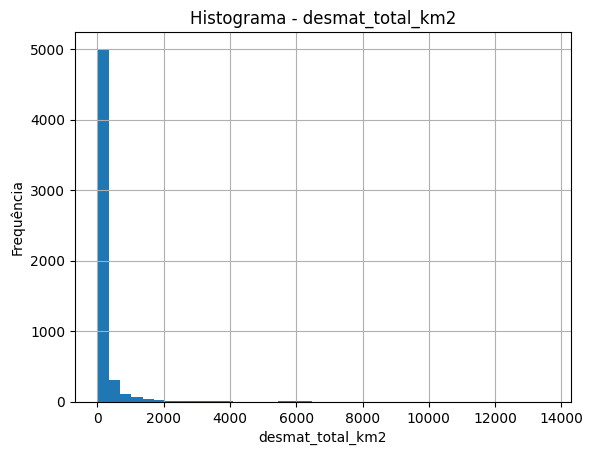

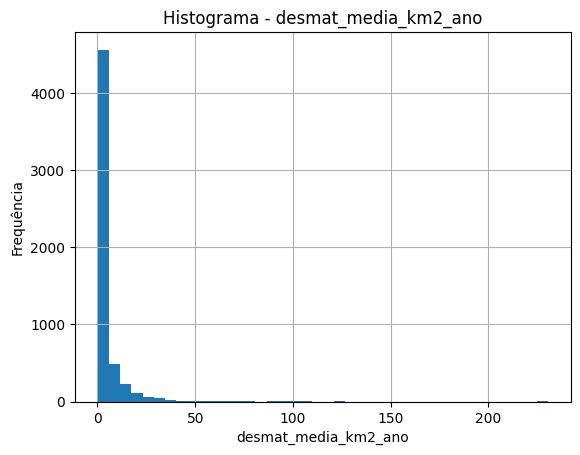

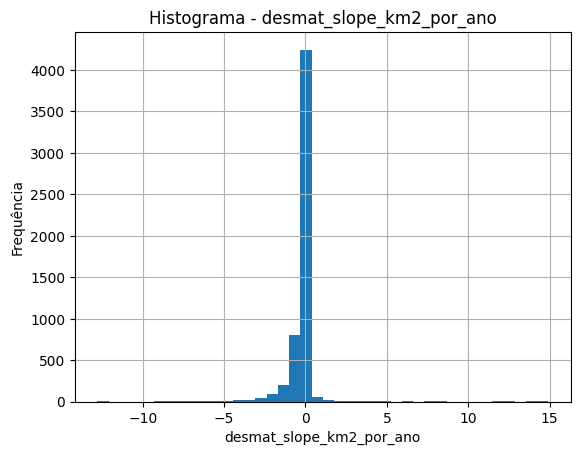

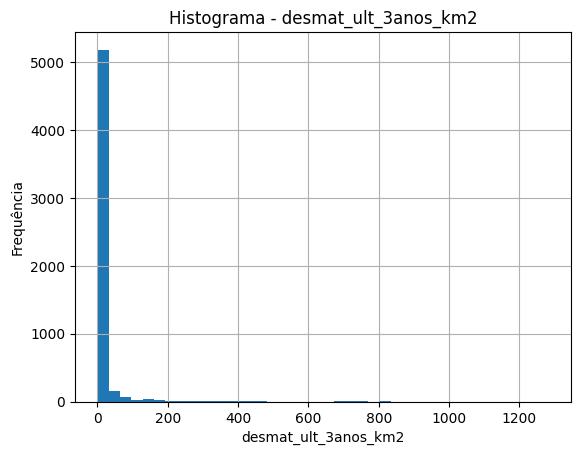

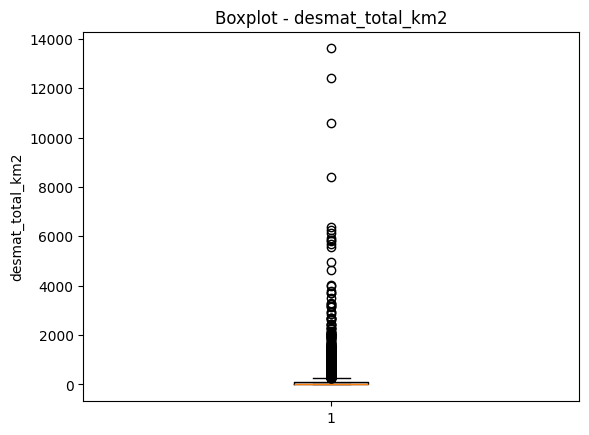

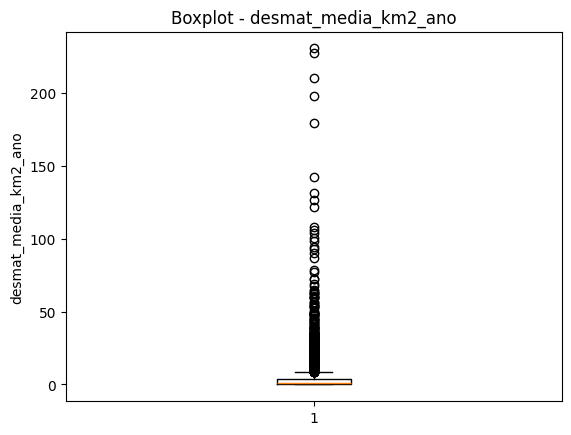

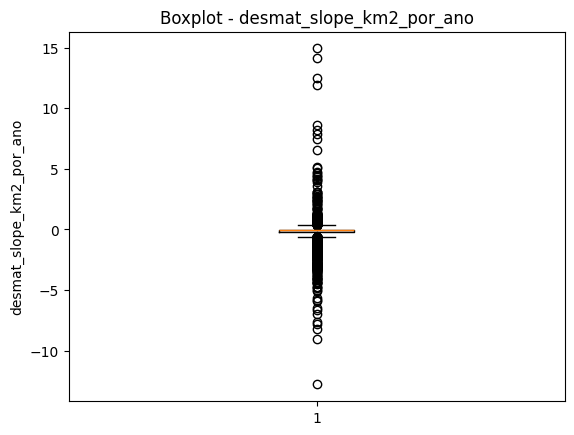

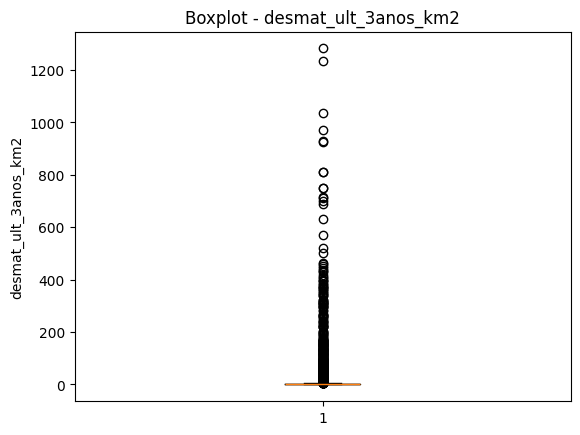

In [98]:
to_plot = [
    "desmat_total_km2",
    "desmat_media_km2_ano",
    "desmat_slope_km2_por_ano",
    "desmat_ult_3anos_km2",
]
to_plot = [c for c in to_plot if c in df.columns]

for col in to_plot:
    plt.figure()
    df[col].replace([np.inf, -np.inf], np.nan).dropna().hist(bins=40)
    plt.title(f"Histograma - {col}")
    plt.xlabel(col)
    plt.ylabel("Frequência")
    plt.show()

for col in to_plot:
    plt.figure()
    plt.boxplot(df[col].replace([np.inf, -np.inf], np.nan).dropna(), vert=True)
    plt.title(f"Boxplot - {col}")
    plt.ylabel(col)
    plt.show()


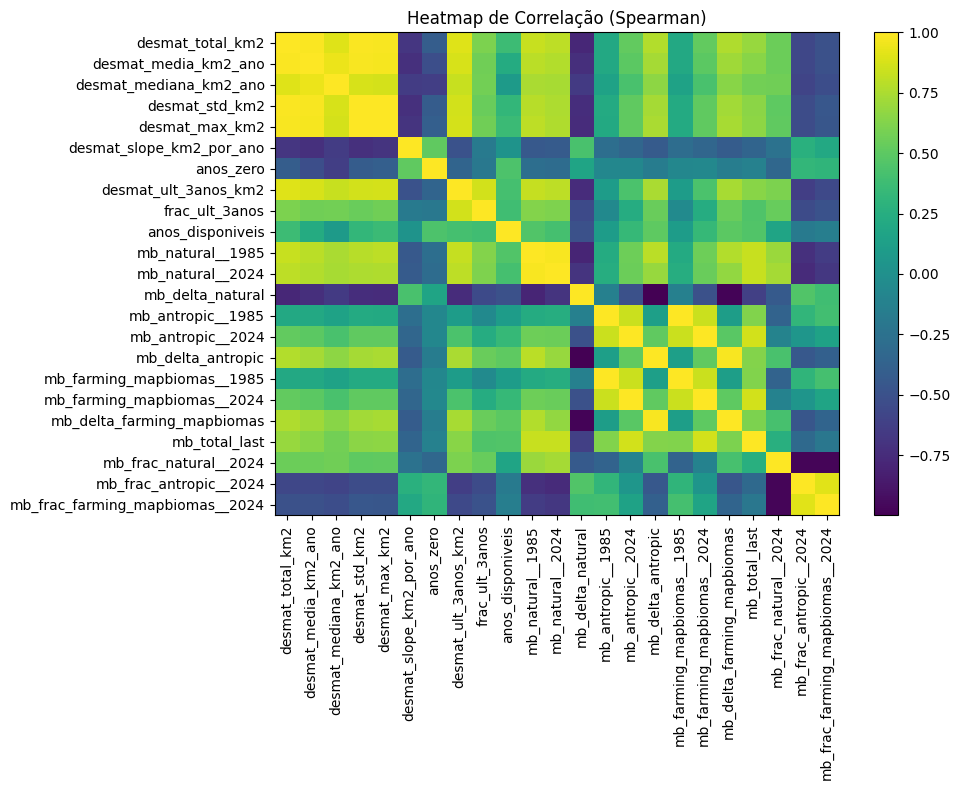

In [99]:
corr_cols = [c for c in numeric_cols if df[c].notna().mean() > 0.7]
corr = df[corr_cols].corr(method="spearman")

plt.figure(figsize=(10,8))
plt.imshow(corr, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr_cols)), corr_cols, rotation=90)
plt.yticks(range(len(corr_cols)), corr_cols)
plt.title("Heatmap de Correlação (Spearman)")
plt.tight_layout()
plt.show()


## 6) Pré-processamento para clusterização

- seleção de features
- imputação (mediana)
- padronização (StandardScaler)


In [100]:
# ==========================================
# 6) Pré-processamento FINAL para clusterização
# ==========================================

from sklearn.preprocessing import StandardScaler
import numpy as np

# Seleção de features
mb_last_year = mb_year_max
mb_last_year = mb_year_max

mb_frac_cols = [
    "mb_frac_natural__2024",
    "mb_frac_antropic__2024"
]

mb_frac_cols = [c for c in mb_frac_cols if c in df.columns]

base_cols = [
    "desmat_total_km2",
    "desmat_media_km2_ano",
    "desmat_std_km2",
    "desmat_slope_km2_por_ano",
    "desmat_ult_3anos_km2",
    "frac_ult_3anos",
    "anos_zero",
]

feat_cols = [c for c in base_cols if c in df.columns] + mb_frac_cols

X = df[feat_cols].copy()

# Remover infinitos
X = X.replace([np.inf, -np.inf], np.nan)

# Imputação
for col in X.columns:
    if X[col].isna().all():
        X[col] = 0
    else:
        X[col] = X[col].fillna(X[col].median())

# Garantia final
print("NaNs antes do scaler:", X.isna().sum().sum())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Checagem FINAL obrigatória
print("NaNs após scaler:", np.isnan(X_scaled).sum())
print("Shape final:", X_scaled.shape)

NaNs antes do scaler: 0
NaNs após scaler: 0
Shape final: (5570, 9)


## 7) PCA (visualização)


NaNs após imputação + scaler: 0


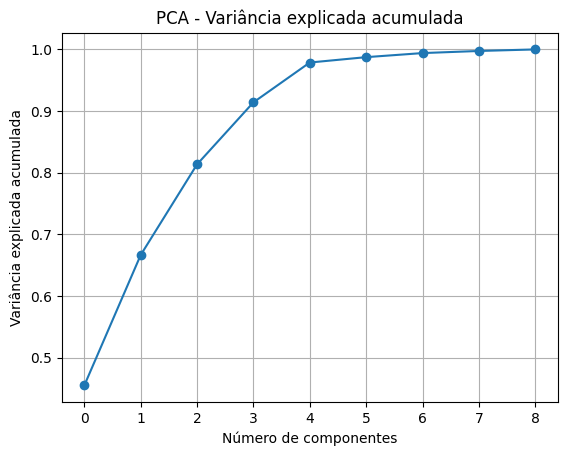

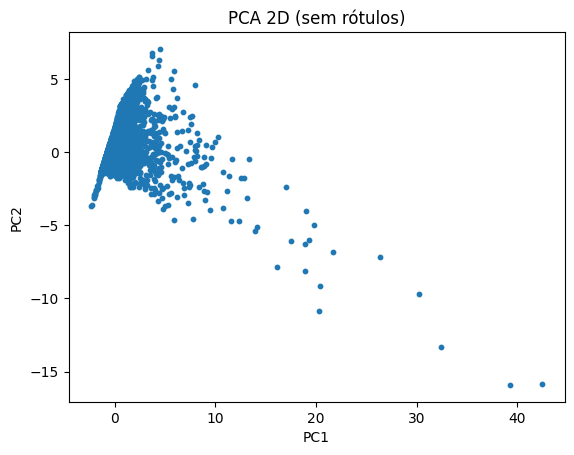

In [101]:
# ============================
# 7) PCA
# ============================

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

# X deve ser o dataframe numérico das features (antes do scaler)
X_pca = df[feat_cols].replace([np.inf, -np.inf], np.nan).copy()

# imputação mediana
imputer = SimpleImputer(strategy="median")
X_imp = imputer.fit_transform(X_pca)

# padronização
scaler = StandardScaler()
X_scaled_pca = scaler.fit_transform(X_imp)

# checagem final
print("NaNs após imputação + scaler:", np.isnan(X_scaled_pca).sum())

pca = PCA(n_components=min(10, X_scaled_pca.shape[1]))
Z = pca.fit_transform(X_scaled_pca)

plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker="o")
plt.title("PCA - Variância explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Variância explicada acumulada")
plt.grid(True)
plt.show()

plt.figure()
plt.scatter(Z[:,0], Z[:,1], s=10)
plt.title("PCA 2D (sem rótulos)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## 8) K-Means (Elbow + métricas)


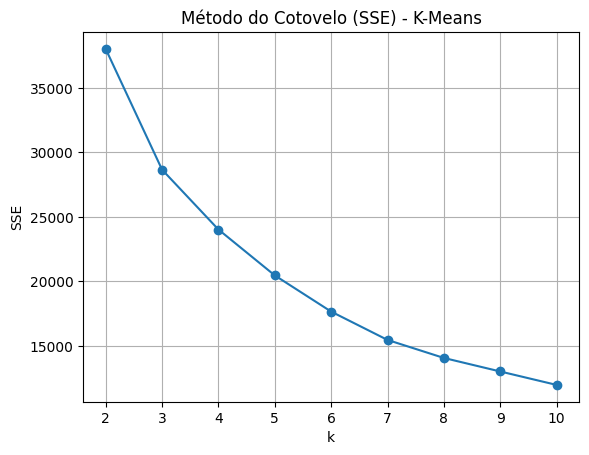

,k,sse,silhouette,davies_bouldin,calinski_harabasz
0,2,38035.113316,0.791015,0.829015,1770.583106
1,3,28666.856440,0.437347,1.099921,2084.033136
2,4,24023.372801,0.419869,1.111799,2016.223786
3,5,20462.391254,0.434405,0.978807,2017.118576
4,6,17654.294728,0.404211,0.969198,2047.035318
5,7,15455.590546,0.400608,0.930466,2080.091864
6,8,14057.146947,0.400337,0.977797,2038.995430
7,9,13007.978693,0.404258,0.944654,1983.741549
8,10,11965.209325,0.322497,0.996203,1970.499552


In [102]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

Ks = list(range(2, 11))
rows = []

for k in Ks:
    km = KMeans(
        n_clusters=k,
        random_state=42,
        n_init=20
    )

    labels = km.fit_predict(X_scaled)

    rows.append({
        "k": k,
        "sse": km.inertia_,
        "silhouette": silhouette_score(X_scaled, labels),
        "davies_bouldin": davies_bouldin_score(X_scaled, labels),
        "calinski_harabasz": calinski_harabasz_score(X_scaled, labels),
    })

metrics_k = pd.DataFrame(rows)

plt.figure()
plt.plot(metrics_k["k"], metrics_k["sse"], marker="o")
plt.title("Método do Cotovelo (SSE) - K-Means")
plt.xlabel("k")
plt.ylabel("SSE")
plt.grid(True)
plt.show()

display(metrics_k)

## 9) Estabilidade (ARI/NMI)


In [103]:
best_k = int(metrics_k.sort_values("silhouette", ascending=False).iloc[0]["k"])
print("K escolhido (melhor silhouette):", best_k)

seeds = [0, 1, 2, 42, 100]
labels_by_seed = {}
for sd in seeds:
    km = KMeans(n_clusters=best_k, random_state=sd, n_init=10)
    labels_by_seed[sd] = km.fit_predict(X_scaled)

pairs = []
for i, s1 in enumerate(seeds):
    for s2 in seeds[i+1:]:
        pairs.append({
            "seed1": s1,
            "seed2": s2,
            "ARI": adjusted_rand_score(labels_by_seed[s1], labels_by_seed[s2]),
            "NMI": normalized_mutual_info_score(labels_by_seed[s1], labels_by_seed[s2]),
        })

stab = pd.DataFrame(pairs)
display(stab)
print("ARI médio:", stab["ARI"].mean().round(3), "| NMI médio:", stab["NMI"].mean().round(3))


K escolhido (melhor silhouette): 2


,seed1,seed2,ARI,NMI
0,0,1,1.000000,1.000000
1,0,2,1.000000,1.000000
2,0,42,1.000000,1.000000
3,0,100,0.980778,0.954795
4,1,2,1.000000,1.000000
5,1,42,1.000000,1.000000
6,1,100,0.980778,0.954795
7,2,42,1.000000,1.000000
8,2,100,0.980778,0.954795
9,42,100,0.980778,0.954795


ARI médio: 0.992 | NMI médio: 0.982


## 10) Agrupamento Hierárquico (Ward)

Devido ao número elevado de amostras, o dendrograma completo torna-se visualmente poluído. Assim, foi utilizada a versão truncada do dendrograma, que evidencia apenas os níveis superiores da hierarquia, permitindo identificar claramente a formação de grandes grupos.


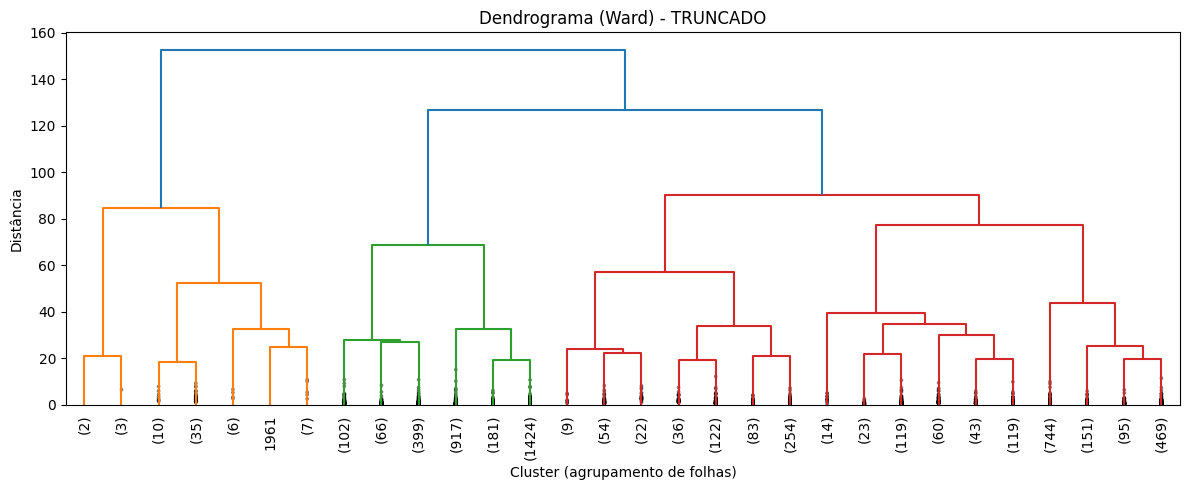

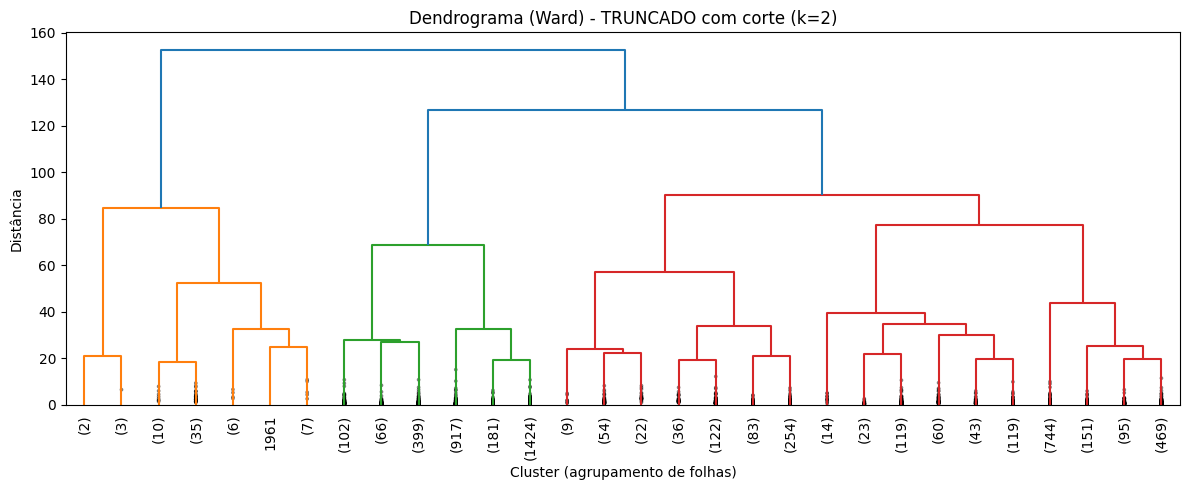

Silhouette (Ward): 0.8045


In [104]:
Z_link = linkage(X_scaled, method="ward")

# Dendrograma truncado
plt.figure(figsize=(12,5))
dendrogram(Z_link, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title("Dendrograma (Ward) - TRUNCADO")
plt.xlabel("Cluster (agrupamento de folhas)")
plt.ylabel("Distância")
plt.tight_layout()
plt.show()

# Dendrograma com corte explícito (k = best_k)
labels_hier = fcluster(Z_link, t=best_k, criterion="maxclust")

plt.figure(figsize=(12,5))
dendrogram(Z_link, truncate_mode="lastp", p=30, leaf_rotation=90, leaf_font_size=10, show_contracted=True)
plt.title(f"Dendrograma (Ward) - TRUNCADO com corte (k={best_k})")
plt.xlabel("Cluster (agrupamento de folhas)")
plt.ylabel("Distância")
plt.tight_layout()
plt.show()

print("Silhouette (Ward):", silhouette_score(X_scaled, labels_hier).round(4))


## 11) DBSCAN (densidade)


In [105]:
eps_values = [0.5, 0.8, 1.0, 1.2]
db_rows = []
for eps in eps_values:
    dbs = DBSCAN(eps=eps, min_samples=10)
    labels = dbs.fit_predict(X_scaled)
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise = float((labels == -1).mean())
    sil = np.nan
    if n_clusters >= 2 and noise < 1.0:
        mask = labels != -1
        if mask.sum() > 10 and len(set(labels[mask])) >= 2:
            sil = silhouette_score(X_scaled[mask], labels[mask])
    db_rows.append({"eps": eps, "n_clusters": n_clusters, "frac_noise": noise, "silhouette_no_noise": sil})

dbscan_metrics = pd.DataFrame(db_rows)
display(dbscan_metrics)


,eps,n_clusters,frac_noise,silhouette_no_noise
0,0.5,2,0.214542,0.345631
1,0.8,5,0.106643,0.343432
2,1.0,2,0.067325,0.599669
3,1.2,1,0.050269,NaN


## 12) Interpretação (clusters + biomas)


In [106]:
km_final = KMeans(n_clusters=best_k, random_state=42, n_init=10)
df["cluster_kmeans"] = km_final.fit_predict(X_scaled)

cluster_profile = df.groupby("cluster_kmeans")[feat_cols].mean()
display(cluster_profile)

if "bioma_ibge" in df.columns:
    cross = pd.crosstab(df["cluster_kmeans"], df["bioma_ibge"], normalize="index") * 100
    display(cross.round(2))


,desmat_total_km2,desmat_media_km2_ano,desmat_std_km2,desmat_slope_km2_por_ano,desmat_ult_3anos_km2,frac_ult_3anos,anos_zero,mb_frac_natural__2024,mb_frac_antropic__2024
cluster_kmeans,,,,,,,,,
0,3013.560602,60.096529,60.968176,1.964344,411.478434,0.172143,7.132530,0.603446,0.198991
1,110.316956,3.325005,3.464204,-0.255470,6.646534,0.029232,6.212685,0.292322,0.362639


bioma_ibge,Amazônia,Caatinga,Cerrado,Mata Atlântica,Pampa,Pantanal
cluster_kmeans,,,,,,
0,65.06,0.00,31.33,0.00,1.2,2.41
1,8.18,19.96,18.88,49.95,2.9,0.13


## ***Variância do PCA:**

In [107]:
print(pca.explained_variance_ratio_)

[0.45503036 0.21149819 0.14703731 0.10057238 0.0646134  0.00870714
 0.00660811 0.00341628 0.00251682]


## ***KMeans vs Ward:**

In [108]:
print("Silhouette KMeans:", silhouette_score(X_scaled, df["cluster_kmeans"]))
print("Silhouette Ward:", silhouette_score(X_scaled, labels_hier))

Silhouette KMeans: 0.7910151384124404
Silhouette Ward: 0.8044659385324423


## 13) Conclusões

A análise de agrupamentos identificou dois perfis principais de municípios brasileiros a partir de indicadores estruturais de desmatamento e uso do solo.

A redução de dimensionalidade via PCA mostrou que os primeiros componentes concentram grande parte da variância (~80% nos três primeiros), indicando que o fenômeno é explicado por poucos fatores dominantes, sobretudo intensidade acumulada, tendência temporal e dinâmica recente.

A escolha de **k = 2** foi sustentada por múltiplos critérios:

* Método do cotovelo (SSE)
* Maior Silhouette médio
* Alta estabilidade (ARI/NMI próximos de 1)
* Consistência com o agrupamento hierárquico (Ward)

Os métodos apresentaram desempenho elevado:

* Silhouette K-Means ~ 0,79
* Silhouette Ward ~ 0,80

Esses valores indicam boa separação entre os grupos e elevada coerência interna dos clusters.

---

## Perfil dos grupos identificados

### Cluster 0: Maior pressão de desmatamento

* Maior desmatamento total acumulado
* Tendência temporal positiva
* Maior intensidade recente (últimos anos)
* Proporção ainda relevante de cobertura natural

Esse perfil é compatível com municípios localizados em frentes ativas de expansão territorial, onde a presença de remanescentes naturais ainda permite continuidade da conversão do uso do solo.

---

### Cluster 1: Menor pressão ou estabilização

* Menor desmatamento acumulado
* Tendência estável ou negativa
* Maior proporção de áreas já consolidadas

Representa municípios com dinâmica recente reduzida, possivelmente associados a regiões com ocupação histórica consolidada ou maior controle territorial.

---

## Relação com uso do solo

As frações de cobertura Natural e Antrópica foram determinantes para diferenciar os grupos, evidenciando que a configuração territorial atual está fortemente associada ao histórico de desmatamento.

A variável *Farming* foi removida devido à colinearidade estrutural, já que as frações de uso do solo somam 1 por definição, o que poderia introduzir redundância na modelagem.

---

## Conclusão geral

O projeto demonstrou que técnicas de clusterização, quando combinadas com padronização adequada, análise exploratória e validação por múltiplas métricas, conseguem identificar padrões estruturais robustos de desmatamento e uso do solo em escala municipal.

Os agrupamentos obtidos foram:

* Estatisticamente consistentes;
* Estáveis sob diferentes inicializações;
* Interpretáveis do ponto de vista ambiental.

Os resultados revelam a existência de regimes territoriais distintos no Brasil, associados a diferentes estágios e dinâmicas de conversão do uso da terra.